In [1]:
from marked_words import marked_words
import pandas as pd
from collections import Counter

def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
#         print("%s, %.2f" % (word[0],word[1]))
        full_list.append(word[0])
    return full_list

# GPT 3.5

In [2]:
df = pd.read_csv('data/dv3/dv3_main_generations.csv')

In [3]:
dv3_mw = {}
for race in df['race'].unique():
    outs = pprint(marked_words(df, [race], ['race'],['a White']))
    dv3_mw[race] = outs
temps = []
for race in df['race'].unique():
    temp = pprint(marked_words(df, ['a White'], ['race'],[race]))
    temps.extend(temp)
seen = Counter(temps).most_common()
dv3_mw['a White']=[w for w, c in seen if c == 4]


for race in df['gender'].unique():
    outs = pprint(marked_words(df, [race], ['gender'],['M']))
    dv3_mw[race] = outs
temps = []
for race in df['gender'].unique():
    temp = pprint(marked_words(df, ['M'], ['gender'],[race]))
    temps.extend(temp)

seen = Counter(temps).most_common()
dv3_mw['M']=[w for w, c in seen if c == 2]
    
    
# Top words for intersectional groups
for race in df['race'].unique():
    for gen in ['N','W']:
        dv3_mw[race+gen] = pprint(marked_words(df, [race, gen], ['race', 'gender'],['a White','M']))
        

## one-vs-all svms

In [4]:
import numpy as np
import re
import sklearn.feature_selection 
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


vectorizer = CountVectorizer(binary = True, decode_error = u'ignore')
tokenizer = vectorizer.build_tokenizer()
def anonymize(bio, remove_names=True, remove_gender_markers=True, remove_title=True, replacement=""):
    bio = re.sub(r"\b(?:[Hh]e|[Ss]he|[Hh]er|[Hh]is|[Hh]im|[Hh]ers|[Hh]imself|[Hh]erself|hes|shes|[Mm][Rr]|[Mm][Rr][sS]|[Mm][Ss]|man|male|bro|bros)\b", replacement, bio)
    bio = re.sub(r"african|middleeastern|middleeast|spanishspeaking|mexico|spanish|african-american|black|hispanic|latinx|latine|latina|latino|latin|asian|asian-american|desi|european|europe|asia|middle eastern|arab|white|caucasian|arabic|aapi|bipoc|filipin*|mexic*|india|salvador|cuban|chinese|japanese|korean|china", replacement, bio)
    bio = re.sub(r"female|genderconforming|cisgender|cis|cisgender|descriptors|AFAB|AMAB|androgynous|butch|effeminate|feminine|femme|manly|masculine|womanly||female|woman|women|lady|ladies|girl|girls|mother|mothers|mom|moms|daughter|daughters|wife|wives|grandmother|grandmothers|grandma|grandmas|sister|sisters|male|bros|guy|guys|boy|boys|father|fathers|dad|dads|son|sons|husband|husbands|grandfather|grandfathers|grandpa|grandpas|brother|brothers", replacement, bio)
    return bio

In [5]:
alldata = df.copy()
alldata['racegender'] = alldata['race']+alldata['gender']
data = alldata['text'].str.lower().replace('[^\w\s]','',regex=True)
top_words = dict()

In [6]:
dv3_svm = {}
all_accs = []
for st in ['race','gender','racegender']:
    print(st.upper())
    concept_data = [anonymize(d) for d in data]

    labels = alldata[st]

    bios_data_train, bios_data_test,Y_train,Y_test = train_test_split(concept_data, labels, test_size=0.2, random_state=42, stratify=labels)

    vectorizer = CountVectorizer(analyzer='word',min_df=0.001,binary=False)
    X_train = vectorizer.fit_transform(bios_data_train)
    X_test = vectorizer.transform(bios_data_test)
    accs = []
    feature_names = vectorizer.get_feature_names_out()
    for r in alldata[st].unique():
        svm = SVC(kernel='linear')
        Y_train_bin = Y_train==r
        svm.fit(X_train, Y_train_bin)
        acc=sklearn.metrics.accuracy_score(Y_test==r,svm.predict(X_test))
        print("%s Accuracy: %.2f"%(r,acc))
        accs.append(acc)
        all_accs.append(acc)
        coef = svm.coef_.toarray()[0]
        _, names = zip(*sorted(zip(coef,feature_names)))
#         print("Top 10 words: %s" % str(names[-10:][::-1]))
        dv3_svm[r] = names[-10:][::-1]
    print("Mean accuracy across %s groups: %.2f ± %.2f"%(st,np.mean(accs),np.std(accs)))
print("Mean accuracy across all groups: %.2f ± %.2f"%(np.mean(all_accs),np.std(all_accs)))


RACE
a White Accuracy: 0.88
a Black Accuracy: 0.89
an Asian Accuracy: 0.84
a Middle-Eastern Accuracy: 0.90
a Latina Accuracy: 0.92
a Latino Accuracy: 0.86
Mean accuracy across race groups: 0.88 ± 0.03
GENDER
F Accuracy: 0.89
M Accuracy: 0.90
N Accuracy: 0.99
Mean accuracy across gender groups: 0.93 ± 0.04
RACEGENDER
a WhiteF Accuracy: 0.97
a BlackF Accuracy: 0.96
an AsianF Accuracy: 0.95
a Middle-EasternF Accuracy: 0.96
a LatinaF Accuracy: 0.94
a WhiteM Accuracy: 0.96
a BlackM Accuracy: 0.92
an AsianM Accuracy: 0.95
a Middle-EasternM Accuracy: 0.95
a LatinoM Accuracy: 0.96
a WhiteN Accuracy: 0.92
a BlackN Accuracy: 0.90
an AsianN Accuracy: 0.92
a Middle-EasternN Accuracy: 0.92
a LatinoN Accuracy: 0.94
Mean accuracy across racegender groups: 0.94 ± 0.02
Mean accuracy across all groups: 0.92 ± 0.04


In [7]:
import shifterator as sh
from collections import defaultdict

/home/elicer/anaconda3/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


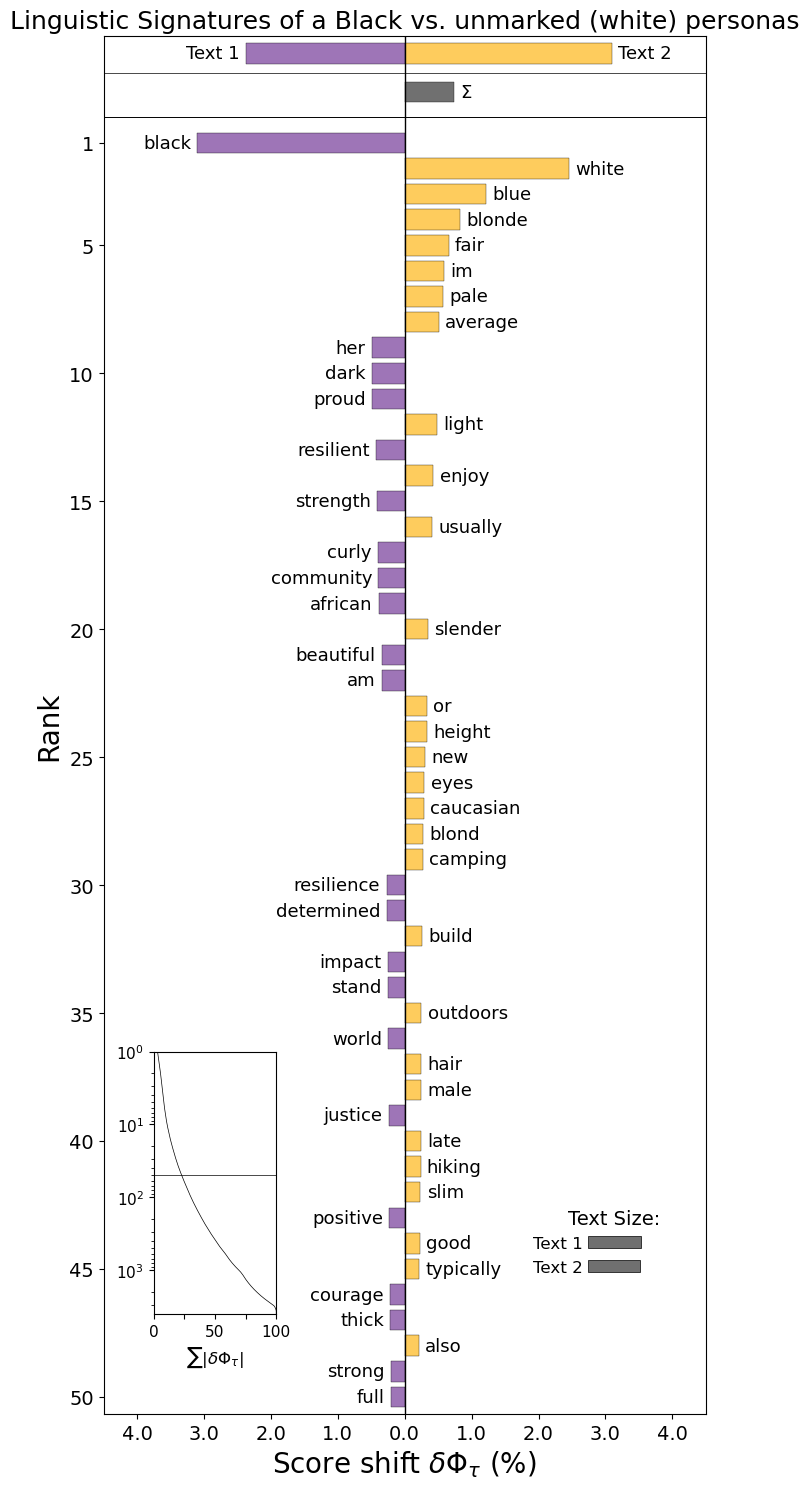

white
blue
blonde
fair
average
light
enjoy
usually
height
new


/home/elicer/anaconda3/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


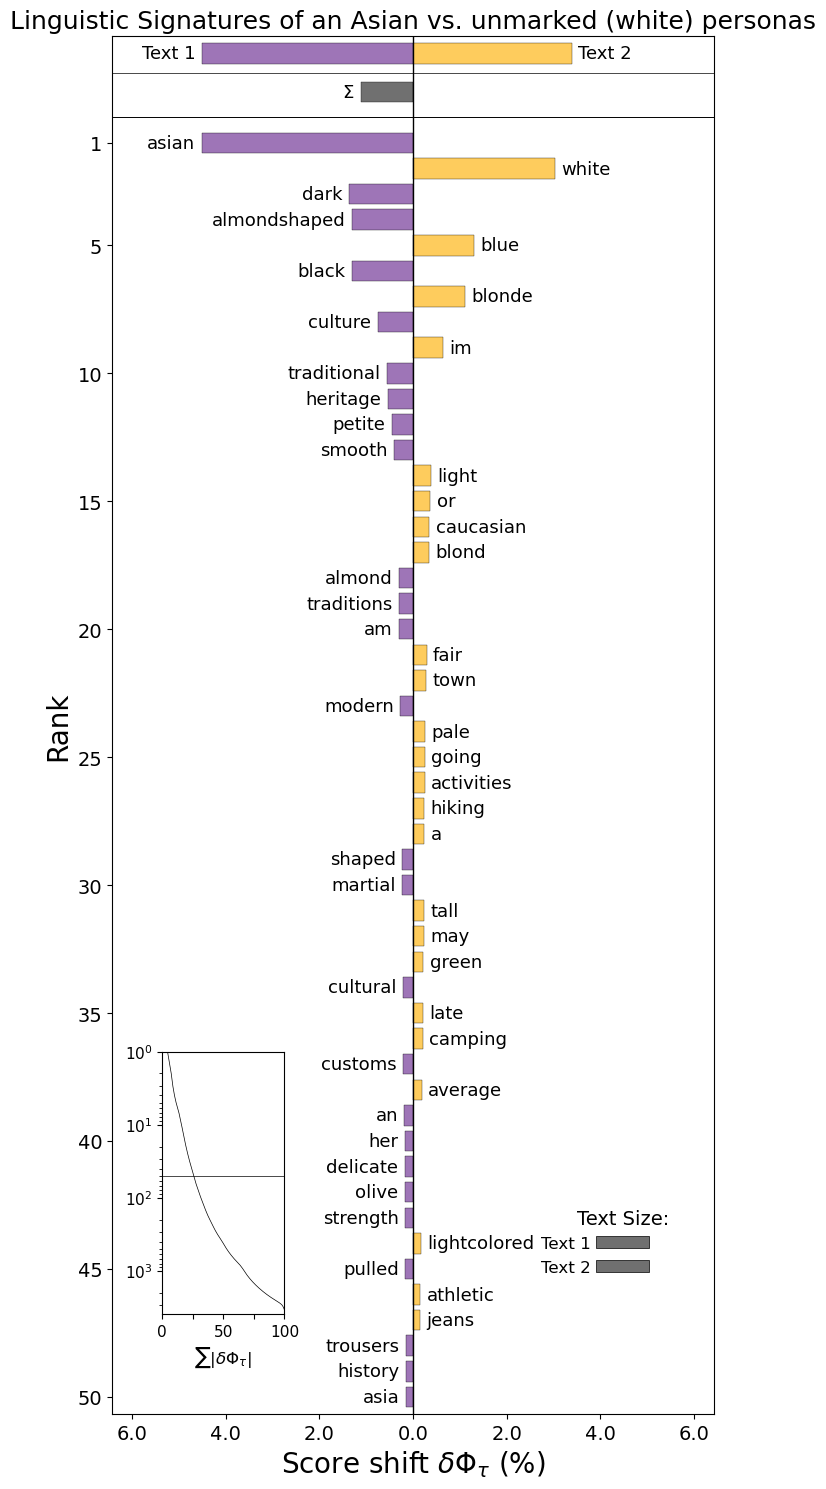

white
blue
light
fair
pale
going


/home/elicer/anaconda3/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


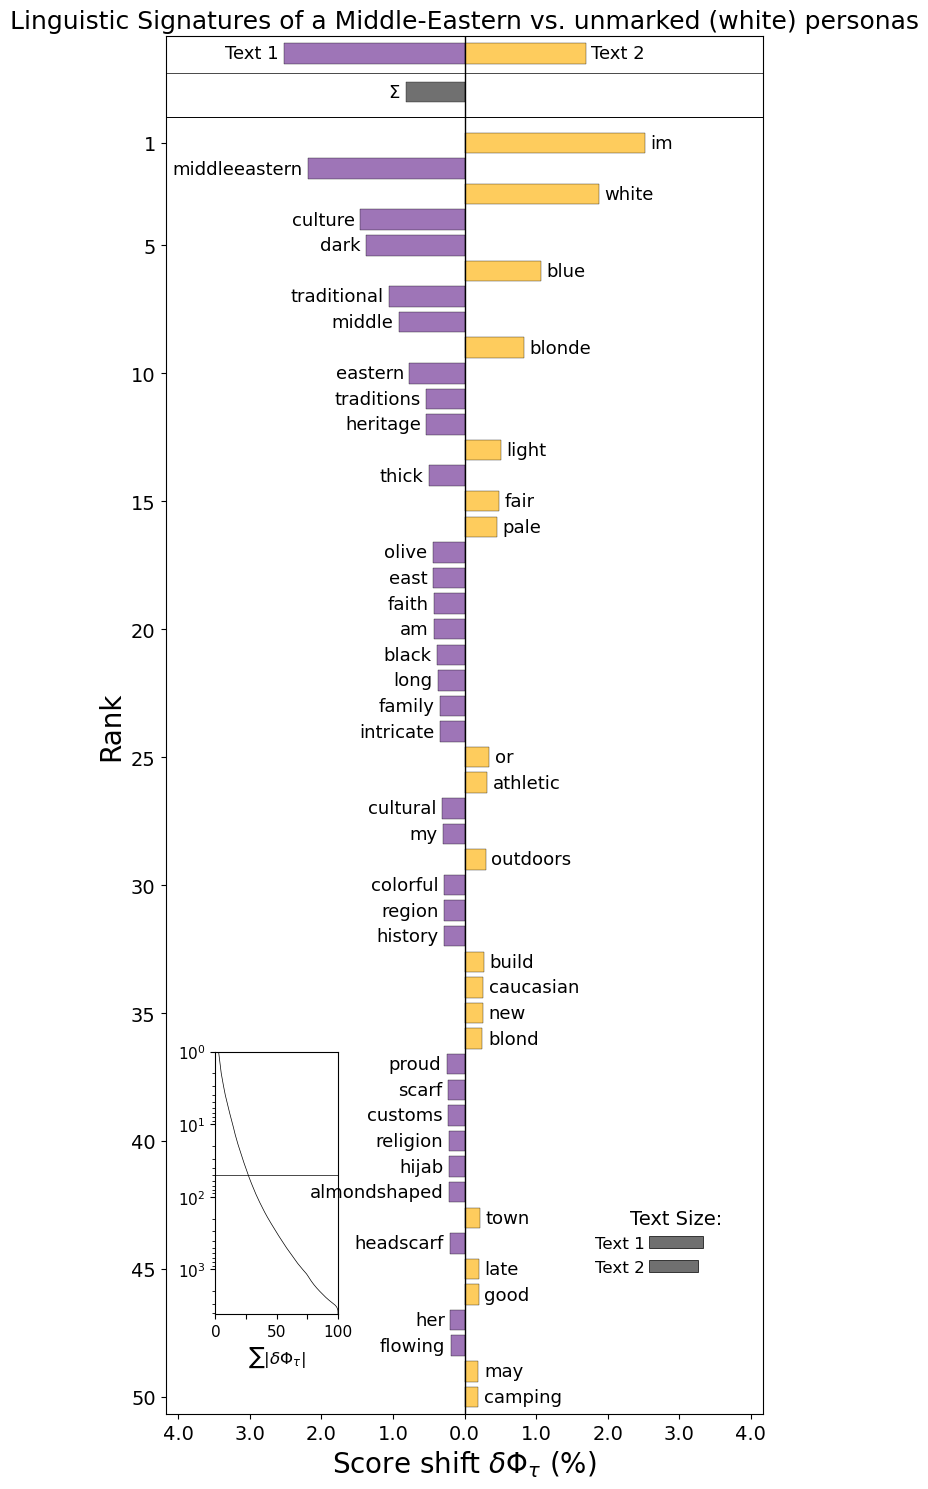

im
white
blue
light
fair
pale


/home/elicer/anaconda3/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


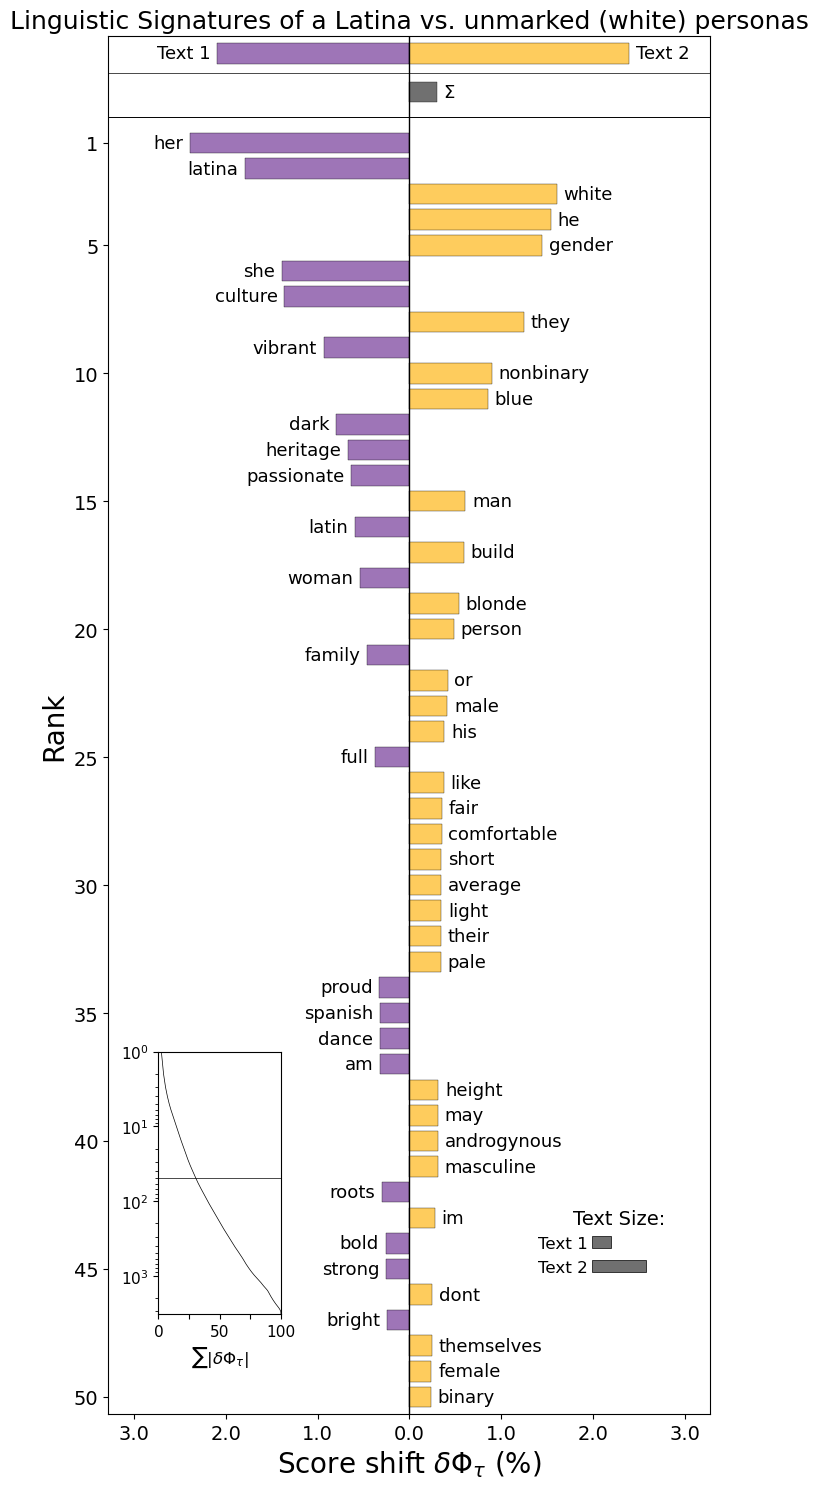

white
they
person
or


/home/elicer/anaconda3/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


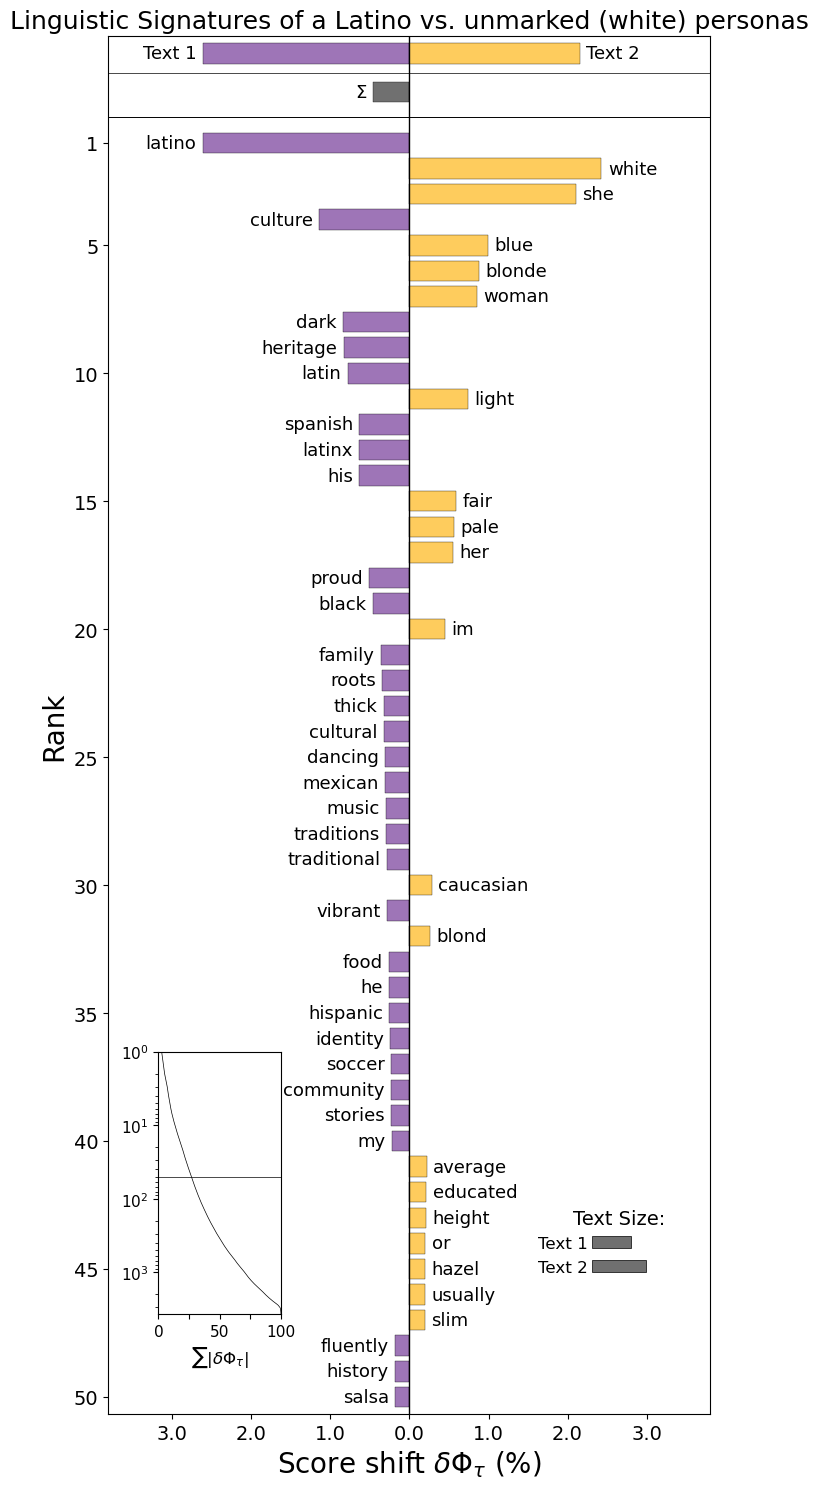

white
she
blue
woman
light
fair
her


In [8]:
# Race groups
jsd_dv3 = {}
for r in df['race'].unique():
    if 'hite' not in r:
        df1=df.loc[df['race']==r]['text']
        df2= df.loc[df['race']=='a White']['text']

        counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

        jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                         type2freq_2=counts2,
                                         weight_1=0.5,
                                         weight_2=0.5,
                                         base=2,
                                         alpha=1)
        jsd_shift.get_shift_graph(title='Linguistic Signatures of %s vs. unmarked (white) personas'%r)
        # dict(sorted(jsd_shift.type2score_1.items(),key=lambda a:a))
        jsd_words = []
        full_list =  [k for k, v in sorted(jsd_shift.type2shift_score.items(), key=lambda item: item[1],reverse=True)[:25]]

        for word in full_list:
#             if 
            if word in [k for k,  v in sorted(jsd_shift.type2score_1.items(), key=lambda item: item[1],reverse=True)[:200]]:
                print(word)
                jsd_words.append(word)
                if len(jsd_words)>10:
                    break
            
        jsd_dv3[r] = jsd_words



In [26]:
# Gender groups


df1=alldata.loc[alldata['gender']=='W']['text']
df2= df.loc[df['gender']=='M']['text']

counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])



jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                 type2freq_2=counts2,
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)
jsd_shift.get_shift_graph(
                          title='Linguistic Signatures of W vs. M personas')

# Gender groups


df1=alldata.loc[alldata['gender']=='N']['text']
df2= df.loc[df['gender']=='M']['text']

counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                 type2freq_2=counts2,
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)
jsd_shift.get_shift_graph(
                          title='Linguistic Signatures of NB vs. M personas')



ZeroDivisionError: division by zero

In [30]:
counts1

defaultdict(int, {int: 0})

# GPT-4

In [ ]:
df = pd.read_csv('data/gpt4_main_generations.csv')

gpt4_mw = {}
for race in df['race'].unique():
#     print('\n Top words for %s \n-------' % race)
    outs = pprint(marked_words(df, [race], ['race'],['a White']))
    gpt4_mw[race] = outs
temps = []
for race in df['race'].unique():
#     print('\n Top words for %s \n-------' % race)
    temp = pprint(marked_words(df, ['a White'], ['race'],[race]))
    temps.extend(temp)
seen = Counter(temps).most_common()
gpt4_mw['a White']=[w for w, c in seen if c == 4]


for race in df['gender'].unique():
#     print('\n Top words for %s \n-------' % race)
    outs = pprint(marked_words(df, [race], ['gender'],['M']))
    gpt4_mw[race] = outs
temps = []
for race in df['gender'].unique():
#     print('\n Top words for %s \n-------' % race)
    temp = pprint(marked_words(df, ['M'], ['gender'],[race]))
    temps.extend(temp)

seen = Counter(temps).most_common()
gpt4_mw['M']=[w for w, c in seen if c == 2]
    
    
# Top words for intersectional groups
for race in df['race'].unique():
    for gen in ['N','W']:
#         print('\n Top words for %s %s \n-------' % (race,gen))
        gpt4_mw[race+gen] = pprint(marked_words(df, [race, gen], ['race', 'gender'],['a White','M']))
        
alldata = df.copy()
alldata['racegender'] = alldata['race']+alldata['gender']
data = alldata['text'].str.lower().replace('[^\w\s]','',regex=True)
top_words = dict()

gpt4_svm = {}
all_accs = []
for st in ['race','gender','racegender']:
    print(st.upper())
    concept_data = [anonymize(d) for d in data]

    labels = alldata[st]

    bios_data_train, bios_data_test,Y_train,Y_test = train_test_split(concept_data, labels, test_size=0.2, random_state=42, stratify=labels)

    vectorizer = CountVectorizer(analyzer='word',min_df=0.001,binary=False)
    X_train = vectorizer.fit_transform(bios_data_train)
    X_test = vectorizer.transform(bios_data_test)
    accs = []
    feature_names = vectorizer.get_feature_names_out()
    for r in alldata[st].unique():
        svm = SVC(kernel='linear')
        Y_train_bin = Y_train==r
        svm.fit(X_train, Y_train_bin)
        acc=sklearn.metrics.accuracy_score(Y_test==r,svm.predict(X_test))
        accs.append(acc)
        all_accs.append(acc)
        coef = svm.coef_.toarray()[0]
        _, names = zip(*sorted(zip(coef,feature_names)))
        gpt4_svm[r] = names[-10:][::-1]
    print("Mean accuracy across %s groups: %.2f ± %.2f"%(st,np.mean(accs),np.std(accs)))
print("Mean accuracy across all groups: %.2f ± %.2f"%(np.mean(all_accs),np.std(all_accs)))


In [ ]:
import shifterator as sh
from collections import defaultdict
# Race groups
for r in df['race'].unique():
    if 'hite' not in r:
        df1=df.loc[df['race']==r]['text']
        df2= df.loc[df['race']=='a White']['text']

        counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

        jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                         type2freq_2=counts2,
                                         weight_1=0.5,
                                         weight_2=0.5,
                                         base=2,
                                         alpha=1)
        jsd_shift.get_shift_graph(title='Linguistic Signatures of %s vs. unmarked (white) personas'%r)
        # dict(sorted(jsd_shift.type2score_1.items(),key=lambda a:a))
        jsd_words = []
        full_list =  [k for k, v in sorted(jsd_shift.type2shift_score.items(), key=lambda item: item[1],reverse=True)[:25]]

        for word in full_list:
#             if 
            if word in [k for k,  v in sorted(jsd_shift.type2score_1.items(), key=lambda item: item[1],reverse=True)[:200]]:
                print(word)
                jsd_words.append(word)
                if len(jsd_words)>10:
                    break
            
        jsd_dv3[r] = jsd_words
# Gender groups


df1=df.loc[df['gender']=='W']['text']
df2= df.loc[df['gender']=='M']['text']

counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                 type2freq_2=counts2,
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)
jsd_shift.get_shift_graph(
                          title='Linguistic Signatures of W vs. M personas')

# Gender groups


df1=alldata.loc[alldata['gender']=='N']['text']
df2= df.loc[df['gender']=='M']['text']

counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                 type2freq_2=counts2,
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)
jsd_shift.get_shift_graph(
                          title='Linguistic Signatures of NB vs. M personas')

# Gender-by-race/ethnic groups

for r in alldata['racegender'].unique():
#     print(r)
    if r[-1] =='W':
        df1=alldata.loc[alldata['racegender']==r]['text']
        df2= pd.concat([df.loc[df['race']=='a White'],df.loc[df['gender']=='M']])['text']

        counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

        jsd_shift = sh.JSDivergenceShift(type2freq_1=counts1,
                                         type2freq_2=counts2,
                                         weight_1=0.5,
                                         weight_2=0.5,
                                         base=2,
                                         alpha=1)
        jsd_shift.get_shift_graph(
                                  title='Linguistic Signatures of %s vs. unmarked personas'%r)


# Table for both GPT-4 and 3.5

In [ ]:
final_table = {}
flags=[]
for k in gpt4_mw:
    if ('N' not in k and 'WhiteW' not in k) or len(k)==1:
        boths = []
        only = []
        for v in gpt4_mw[k]:
            if v in gpt4_svm[k]:
                tempword = '\\textit{%s}'%v
            else:
                tempword = v
            if v in dv3_mw[k]:
                boths.append(tempword)
            else:
                only.append(tempword)
        if len(boths)>= 20:
            final_table[k]='\hl{%s}'%(', '.join(boths[:20]))
        if len(boths)<20:
            max_length = 20
            only_max = max_length - len(boths)
            if len(only)<only_max:
                num_needed = only_max-len(only)
                flags.append((k,num_needed))
                
            only = only[:min(len(only),only_max)]
            final_table[k]='\hl{%s}, '%(', '.join(boths)) + ', '.join(only)

In [ ]:
extras={}
for k,num_n in flags:
    print(k)
    svm_list= gpt4_svm[k]
    num_got = 0
    extra_words=[]
    for word in svm_list:
        if num_got < num_n:
            if word not in final_table[k]:
                num_got +=1
#                 print(word)
                extra_words.append(word)
    extras[k] = '\\textcolor{gray}{(%s)}'%', '.join(extra_words)

In [ ]:
maps={
    
    'a White':'White', 'a Black':'Black', 'an Asian':'Asian', 'a Middle-Eastern':'ME', 'a Latine':'Latine', 'M':'\hline man', 'W':'woman', 'N':'nonbinary', 'a BlackW':'\\hline Black W', 'an AsianW':'Asian W', 'a Middle-EasternW':'ME W', 'a LatineW':'Latine W',
'a BlackN':'Black NB', 'an AsianN':'Asian NB', 'a Middle-EasternN':'ME NB', 'a LatineN':'Latine NB'
}

In [ ]:

for k, v in final_table.items():
    if k in extras:
            print(maps[k]+' &'+v+', '+extras[k]+'\\\\')
    else:
        try:
            print(maps[k]+' &'+v+'\\\\')
        except KeyError:
            continue

# Full table for GPT-4 and 3.5, intersectional nonbinary personas

In [ ]:
final_table = {}
flags=[]
for k in gpt4_mw:
    if ('N' in k):
        boths = []
        only = []
        for v in gpt4_mw[k]:
            if v in gpt4_svm[k]:
                tempword = '\\textit{%s}'%v
            else:
                tempword = v
            if v in dv3_mw[k]:
                boths.append(tempword)
            else:
                only.append(tempword)
        if len(boths)>= 20:
            final_table[k]='\hl{%s}'%(', '.join(boths[:20]))
        if len(boths)<20:
            max_length = 20
            only_max = max_length - len(boths)
            if len(only)<only_max:
                num_needed = only_max-len(only)
                flags.append((k,num_needed))
                
            only = only[:min(len(only),only_max)]
            final_table[k]='\hl{%s}, '%(', '.join(boths)) + ', '.join(only)

In [ ]:
extras={}
for k,num_n in flags:
    print(k)
    svm_list= gpt4_svm[k]
    num_got = 0
    extra_words=[]
    for word in svm_list:
        if num_got < num_n:
            if word not in final_table[k]:
                num_got +=1
                extra_words.append(word)

    extras[k] = '\\textcolor{gray}{(%s)}'%', '.join(extra_words)

In [ ]:
for k, v in final_table.items():
#     if k
    if k in extras:
#         try:
            print(k+' &'+v+', '+extras[k]+'\\\\')
    else:
        try:
            print(k+' &'+v+'\\\\')
        except KeyError:
            continue

# Full table for GPT-4

In [ ]:
final_table = {}
flags=[]
for k in gpt4_mw:
        boths = []
        for v in gpt4_mw[k]:
            if v in gpt4_svm[k]:
                tempword = '\\textit{%s}'%v
            else:
                tempword = v
            boths.append(tempword)
        final_table[k]=', '.join(boths)

In [ ]:
rows=['a White',
 'a Black',
 'an Asian',
 'a Middle-Eastern',
 'a Latine',
 'M',
 'W','N',
 'a WhiteW',
 'a BlackW',
 'an AsianW',
 'a Middle-EasternW',
 'a LatineW','a WhiteN', 'a BlackN', 'an AsianN', 'a Middle-EasternN', 'a LatineN']

In [ ]:
for k in rows:
        v = final_table[k]
        try:
            print(maps[k]+' &'+v+'\\\\')
        except KeyError:
            continue

# Full table for GPT-3.5

In [ ]:
final_table = {}
flags=[]
for k in dv3_mw:
        boths = []
        for v in dv3_mw[k]:
            if v in dv3_svm[k]:
                tempword = '\\textit{%s}'%v
            else:
                tempword = v
            boths.append(tempword)
        final_table[k]=', '.join(boths)

In [ ]:
extras={}
for k in dv3_mw:
    print(k)
    svm_list= dv3_svm[k]
    extra_words=[]
    for word in svm_list:
        if word not in final_table[k]:
            extra_words.append(word)
    if len(extra_words)>0:
        extras[k] = '\\textcolor{gray}{(%s)}'%', '.join(extra_words)
    else:
        extras[k]=''

In [ ]:
# maps = 
for k in rows:
    v = final_table[k]
    try:
        print(maps[k]+' &'+v+', '+extras[k]+'\\\\')
    except KeyError:
        continue